In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [3]:
# Load dataset
data = pd.read_csv("data.csv")  # Update with the correct path

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 899 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             899 non-null    int64  
 1   Sex             899 non-null    object 
 2   ChestPainType   899 non-null    object 
 3   RestingBP       899 non-null    int64  
 4   Cholesterol     899 non-null    int64  
 5   FastingBS       899 non-null    int64  
 6   RestingECG      899 non-null    object 
 7   MaxHR           899 non-null    int64  
 8   ExerciseAngina  899 non-null    object 
 9   Oldpeak         899 non-null    float64
 10  ST_Slope        899 non-null    object 
 11  HeartDisease    899 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 91.3+ KB

Dataset Description:
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  899.000000  899.000000   899.000000  899.000000  899.000000   
mean    53.497219  132.0

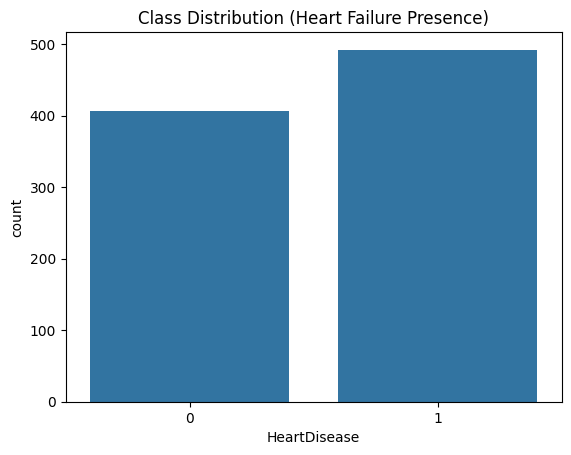

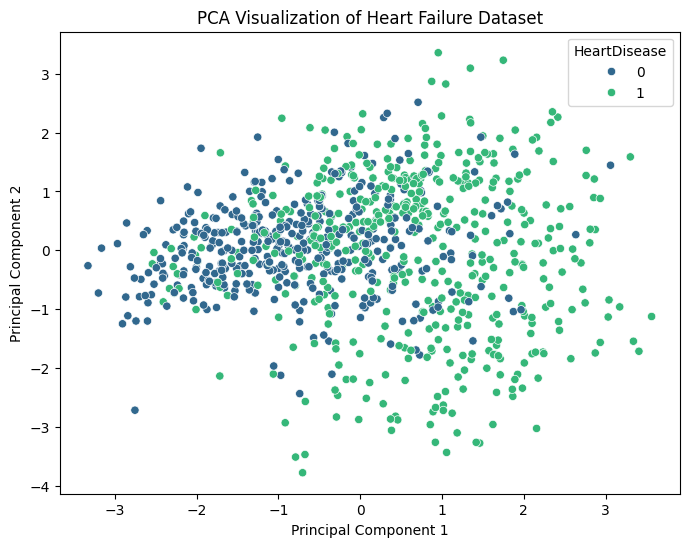

Original dataset size: 899
Dataset size after removing outliers: 890
Number of rows removed: 9


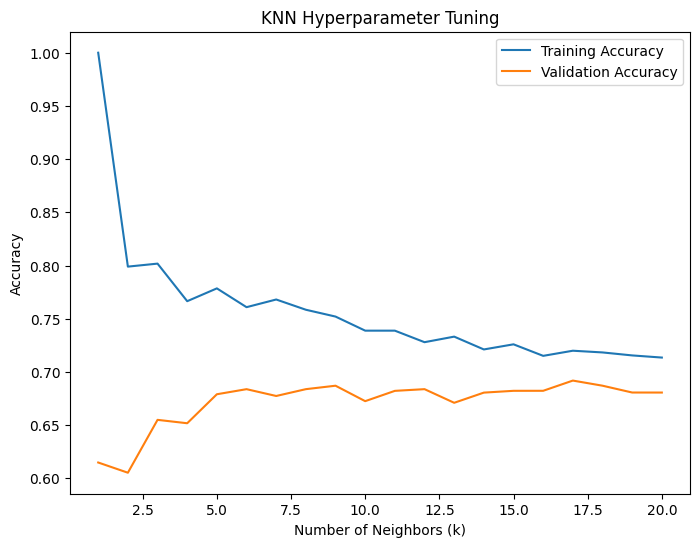

Best parameters for KNN: {'n_neighbors': 17}
Validation Metrics for KNN:
              precision    recall  f1-score   support

           0       0.65      0.70      0.67        57
           1       0.76      0.71      0.73        76

    accuracy                           0.71       133
   macro avg       0.70      0.71      0.70       133
weighted avg       0.71      0.71      0.71       133



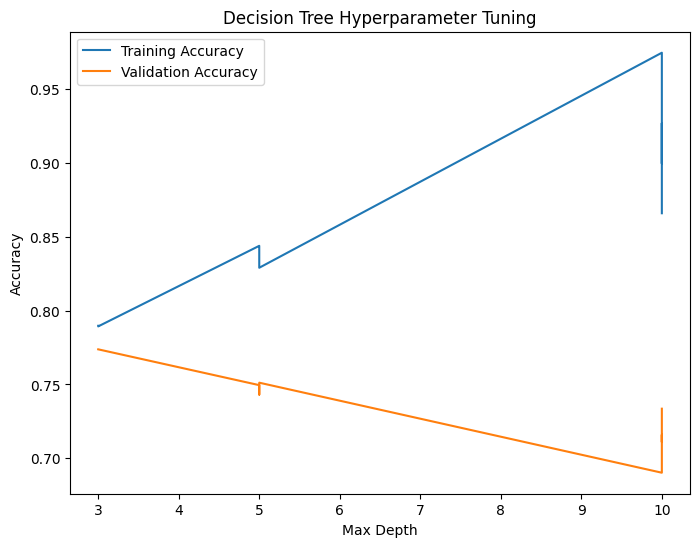

Best parameters for Decision Tree: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Validation Metrics for Decision Tree:
              precision    recall  f1-score   support

           0       0.72      0.84      0.77        57
           1       0.86      0.75      0.80        76

    accuracy                           0.79       133
   macro avg       0.79      0.80      0.79       133
weighted avg       0.80      0.79      0.79       133


Testing KNN:
              precision    recall  f1-score   support

           0       0.68      0.71      0.69        59
           1       0.76      0.73      0.75        75

    accuracy                           0.72       134
   macro avg       0.72      0.72      0.72       134
weighted avg       0.73      0.72      0.72       134



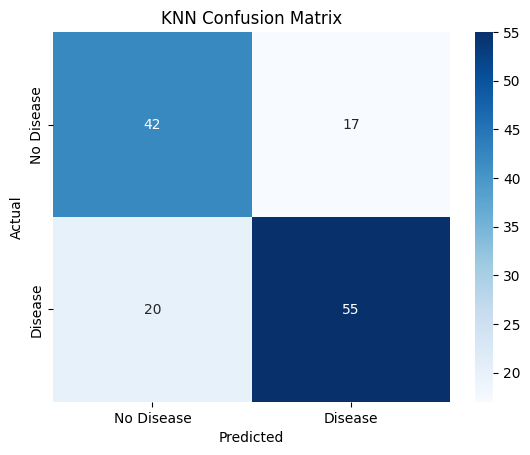


Testing Decision Tree:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        59
           1       0.85      0.80      0.82        75

    accuracy                           0.81       134
   macro avg       0.80      0.81      0.80       134
weighted avg       0.81      0.81      0.81       134



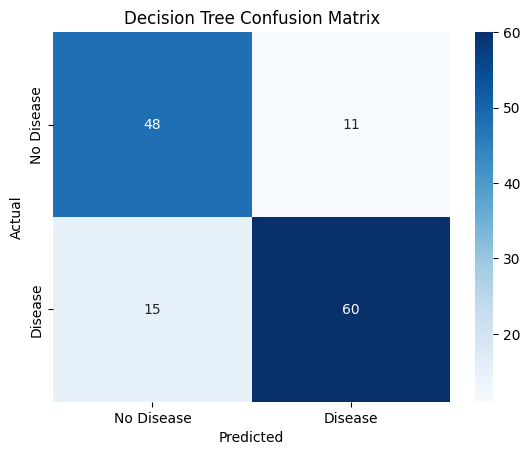

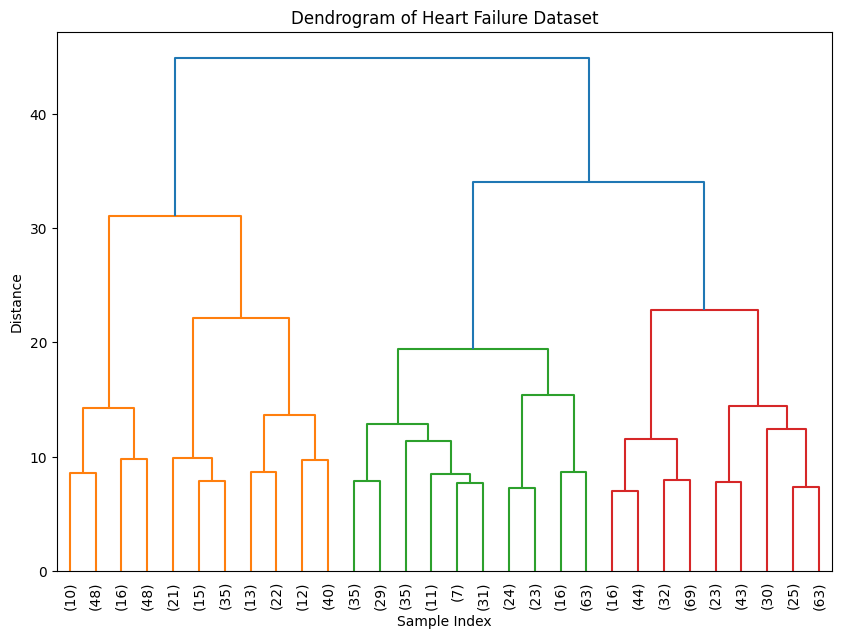

In [5]:
# Step 1: Data Exploration and Visualization
print("Dataset Information:")
data.info()
print("\nDataset Description:")
print(data.describe())

# Visualize class distribution
sns.countplot(x=data['HeartDisease'])
plt.title('Class Distribution (Heart Failure Presence)')
plt.show()

# PCA for HeartDisease
numeric_columns = data.select_dtypes(include=np.number).columns.drop('HeartDisease')
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[numeric_columns])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=data['HeartDisease'], palette='viridis')
plt.title('PCA Visualization of Heart Failure Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Step 2: Data Cleaning and Processing
# Handle missing values
if data.isnull().sum().any():
    data.fillna(data.median(), inplace=True)

# Handle outliers using Zscore
z_scores = np.abs(zscore(data[numeric_columns]))
threshold = 3  # Common threshold for outlier detection
data_cleaned = data[(z_scores < threshold).all(axis=1)]

# Show the number of rows removed due to outliers
print(f"Original dataset size: {len(data)}")
print(f"Dataset size after removing outliers: {len(data_cleaned)}")
print(f"Number of rows removed: {len(data) - len(data_cleaned)}")

# Use cleaned data after Z-score filtering
data = data_cleaned

# Handle duplicates
data = data.drop_duplicates()

# Split data into train, validation, and test sets
X = data[numeric_columns]
y = data['HeartDisease']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Training Classifiers (KNN and Decision Tree)
results = {}

# KNN
knn = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': range(1, 21)}
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', return_train_score=True)
grid_knn.fit(X_train, y_train)

# Plot training and validation accuracy for KNN
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), grid_knn.cv_results_['mean_train_score'], label='Training Accuracy')
plt.plot(range(1, 21), grid_knn.cv_results_['mean_test_score'], label='Validation Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Hyperparameter Tuning')
plt.legend()
plt.show()

print("Best parameters for KNN:", grid_knn.best_params_)
y_pred_val_knn = grid_knn.predict(X_val)
print("Validation Metrics for KNN:")
print(classification_report(y_val, y_pred_val_knn))
results['KNN'] = grid_knn.best_estimator_

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy', return_train_score=True)
grid_dt.fit(X_train, y_train)

# Plot training and validation accuracy for Decision Tree
plt.figure(figsize=(8, 6))
plt.plot(grid_dt.cv_results_['param_max_depth'].data, grid_dt.cv_results_['mean_train_score'], label='Training Accuracy')
plt.plot(grid_dt.cv_results_['param_max_depth'].data, grid_dt.cv_results_['mean_test_score'], label='Validation Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Hyperparameter Tuning')
plt.legend()
plt.show()

print("Best parameters for Decision Tree:", grid_dt.best_params_)
y_pred_val_dt = grid_dt.predict(X_val)
print("Validation Metrics for Decision Tree:")
print(classification_report(y_val, y_pred_val_dt))
results['Decision Tree'] = grid_dt.best_estimator_

# Step 4: Testing
for name, model in results.items():
    print(f"\nTesting {name}:")
    y_pred_test = model.predict(X_test)
    print(classification_report(y_test, y_pred_test))
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Step 5: Dendrogram Analysis
linked = linkage(data_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.title('Dendrogram of Heart Failure Dataset')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Observations on trends
# - For KNN: As the number of neighbors increases, the training accuracy decreases while validation accuracy stabilizes.
# - For Decision Trees: Increasing tree depth improves training accuracy but may overfit, as seen in reduced validation accuracy at very high depths.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("heart_failure_dataset.csv")  # Update with the correct path

# Step 1: Data Exploration and Visualization
print("Dataset Information:")
data.info()
print("\nDataset Description:")
print(data.describe())

# Visualize class distribution
sns.countplot(x=data['target'])
plt.title('Class Distribution (Heart Failure Presence)')
plt.show()

# PCA for visualization
numeric_columns = data.select_dtypes(include=np.number).columns.drop('target')
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[numeric_columns])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=data['target'], palette='viridis')
plt.title('PCA Visualization of Heart Failure Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Step 2: Data Cleaning and Processing
# Handle missing values
if data.isnull().sum().any():
    data.fillna(data.median(), inplace=True)

# Handle outliers using IQR
for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.clip(data[col], lower_bound, upper_bound)

# Handle duplicates
data = data.drop_duplicates()

# Split data into train, validation, and test sets
X = data[numeric_columns]
y = data['target']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Training Classifiers (Naïve Bayes and SVM)
results = {}

# Naïve Bayes with hyperparameter tuning
param_grid_nb = {'var_smoothing': np.logspace(-9, -6, num=4)}
grid_nb = GridSearchCV(GaussianNB(), param_grid_nb, cv=5, scoring='accuracy', return_train_score=True)
grid_nb.fit(X_train, y_train)

# Plot training and validation accuracy for Naïve Bayes
plt.figure(figsize=(8, 6))
plt.plot(grid_nb.cv_results_['mean_train_score'], label='Training Accuracy')
plt.plot(grid_nb.cv_results_['mean_test_score'], label='Validation Accuracy')
plt.xlabel('Hyperparameter Configuration Index')
plt.ylabel('Accuracy')
plt.title('Naïve Bayes Hyperparameter Tuning')
plt.legend()
plt.show()

print("Best parameters for Naïve Bayes:", grid_nb.best_params_)
y_pred_val_nb = grid_nb.predict(X_val)
print("Validation Metrics for Naïve Bayes:")
print(classification_report(y_val, y_pred_val_nb))
results['Naïve Bayes'] = grid_nb.best_estimator_

# SVM with hyperparameter tuning
svc = SVC()
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1]
}
grid_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy', return_train_score=True)
grid_svc.fit(X_train, y_train)

# Plot training and validation accuracy for SVM
plt.figure(figsize=(8, 6))
plt.plot(grid_svc.cv_results_['mean_train_score'], label='Training Accuracy')
plt.plot(grid_svc.cv_results_['mean_test_score'], label='Validation Accuracy')
plt.xlabel('Hyperparameter Configuration Index')
plt.ylabel('Accuracy')
plt.title('SVM Hyperparameter Tuning')
plt.legend()
plt.show()

print("Best parameters for SVM:", grid_svc.best_params_)
y_pred_val_svc = grid_svc.predict(X_val)
print("Validation Metrics for SVM:")
print(classification_report(y_val, y_pred_val_svc))
results['SVM'] = grid_svc.best_estimator_

# Step 4: Testing
for name, model in results.items():
    print(f"\nTesting {name}:")
    y_pred_test = model.predict(X_test)
    print(classification_report(y_test, y_pred_test))
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Observations on trends
# - Naïve Bayes: Performs well with fewer hyperparameter tuning options.
# - SVM: Achieves higher accuracy with optimal gamma and C values. Larger C values may overfit.
